# SRules

# Statics

In [11]:
import dask.dataframe as dd
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics


## Load Dataset

In [12]:

from notebooks.SRules.read_datasets import read_dataset

filename = "SPECT"
test_size=0.1
path = f'../..'
dataset_path_name = f'{path}/data/{filename}.csv'
X, y, dataset, target_value_name, pandas_dataset = read_dataset(filename, dataset_path_name)

pandas_dataset.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F14,F15,F16,F17,F18,F19,F20,F21,F22,Class
0,False,False,False,True,False,False,False,True,True,False,...,True,False,False,False,False,False,False,False,False,True
1,False,False,True,True,False,False,False,True,True,False,...,True,False,False,False,False,False,False,False,True,True
2,True,False,True,False,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
4,False,False,False,False,False,False,False,True,False,False,...,False,True,True,False,False,False,False,False,False,True


In [13]:
#Define dataset
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=test_size, random_state=1)
encoded_train_pandas_dataset = pd.DataFrame(data= np.c_[X_train, y_train], columns= list(dataset['feature_names']) + [target_value_name])
encoded_test_pandas_dataset = pd.DataFrame(data= np.c_[X_test, y_test], columns= list(dataset['feature_names']) + [target_value_name])
print('Sizes (without target):')
print(f'Original size {dataset.data.shape}')
print(f'Train size {X_train.shape}')
print(f'Test size {X_test.shape}')
print(f'encoded_train_pandas_dataset size {encoded_train_pandas_dataset.shape}')
print(f'encoded_test_pandas_dataset size {encoded_test_pandas_dataset.shape}')

Sizes (without target):
Original size (267, 22)
Train size (240, 22)
Test size (27, 22)
encoded_train_pandas_dataset size (240, 23)
encoded_test_pandas_dataset size (27, 23)


## Define Random Forest

In [14]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer, recall_score, accuracy_score
from lightgbm import LGBMClassifier

# Define scorer
ensemble = RandomForestClassifier()
ensemble.fit(X_train, y_train)

RandomForestClassifier()

## SRules

->TRAINING MODEL
->Extract feature importance list


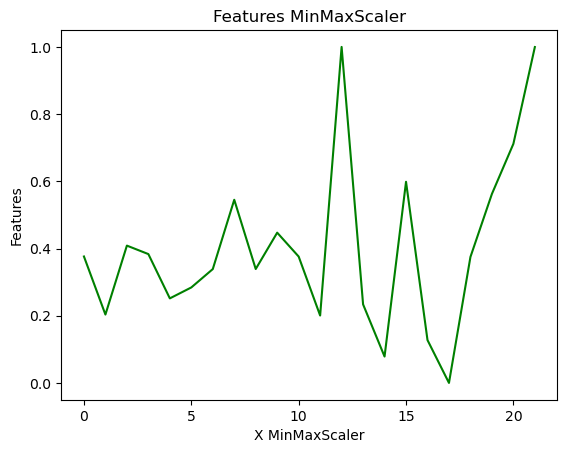

	 Original features 22
	 Selected features 20
	 Percentage of selected rules: 90.9090909090909 %
->Generate new tree based on list
Elapsed time to compute the binary_tree_generator: 1.894 seconds
->Generate obtained patterns tree
Elapsed time to compute the obtain_pattern_list_of_valid_nodes_with_pvalue: 0.023 seconds
->Categorize patterns
Elapsed time to compute the categorize_patterns: 0.066 seconds
->Prune Rules
Elapsed time to compute the prune_rules: 0.000 seconds
Elapsed TOTAL TIME: 2.242 seconds


In [15]:
from SRules.SRules import SRules

import time
start_time = time.time()
rules = SRules(
                feature_names=dataset.feature_names,
                target_value_name = dataset.target_names,
                display_features = True,
                display_logs = True,
                chi_square_percent_point_function = 0.99,
                scale_feature_coefficient = 0.1,
                min_accuracy_coefficient = 0.95,
                min_number_class_per_node = 5
            )
# Fit model
rules.fit(ensemble, X_train, y_train, encoded_train_pandas_dataset, ensemble.feature_importances_)

elapsed_time = time.time() - start_time
print(f"Elapsed TOTAL TIME: {elapsed_time:.3f} seconds")

# Print Model

In [16]:
print(rules)

> ++++++++++++++++++++++++++++
> SRules --  Number of Rules: 4
> SRules --  Number of Minimal Rules: 2
> ++++++++++++++++++++++++++++
> ------------------------------
 ** Target value: True ** Target: 73 ** Total: 73 ** Accuracy: 1.0 ** Complexity: 2 ** Chi2 critical_value: 6.6348966010212145 ** P_value: 0.002898372517161762
	 Query: F13 == True  &  F22 == True
> ------------------------------
> ------------------------------
 ** Target value: True ** Target: 111 ** Total: 116 ** Accuracy: 0.9568965517241379 ** Complexity: 1 ** Chi2 critical_value: 6.6348966010212145 ** P_value: 4.170352099665653e-09
	 Query: F13 == True
> ------------------------------


# Predict

In [17]:
# ENSEMBLE
y_pred_test_ensemble = ensemble.predict(X_test)

# RULES
y_pred_test_rules = rules.predict(X_test, sorting_method="target_accuracy")

In [18]:
# CATEGORIZABLES
np_array_rules = np.array(y_pred_test_rules)
#not_filter_indices = np.where(np.logical_and(np_array_rules != 0, np_array_rules!=1))[0]
filter_indices = np.where(np_array_rules != None)[0]


np_filterred_y_test = np.array(y_test)[filter_indices]
np_filterred_y_pred_test_ensemble = np.array(y_pred_test_ensemble)[filter_indices]
np_filterred_y_pred_test_rules = np.array(y_pred_test_rules)[filter_indices]
# CHANGE FORMAT IN ORDER TO NOT HAVE PROBLEMS
np_filterred_y_pred_test_rules = np_filterred_y_pred_test_rules.astype('int64')


print(f'DATASET TEST: {len(y_test)}')
print(f'DATASET TEST categorizable: {len(np_filterred_y_test)}')
print('Cobertura:',str("{:.2f}".format(100*(len(np_filterred_y_pred_test_rules)/len(y_test))))+'%')

ensemble_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF accuracy:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
ensemble_accuracy = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF F1-score:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
rules_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules Accuracy:',str("{:.2f}".format(100*rules_accuracy))+'%')
rules_F1 = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules F1-score:',str("{:.2f}".format(100*rules_F1))+'%')
rules_roc_auc = metrics.roc_auc_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules roc_auc_score:',str("{:.2f}".format(100*rules_roc_auc))+'%')


DATASET TEST: 27
DATASET TEST categorizable: 16
Cobertura: 59.26%
RF accuracy: 87.50%
RF F1-score: 93.33%
Rules Accuracy: 87.50%
Rules F1-score: 93.33%
Rules roc_auc_score: 50.00%


In [19]:
print(type(ensemble))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


# SHAP explainer

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


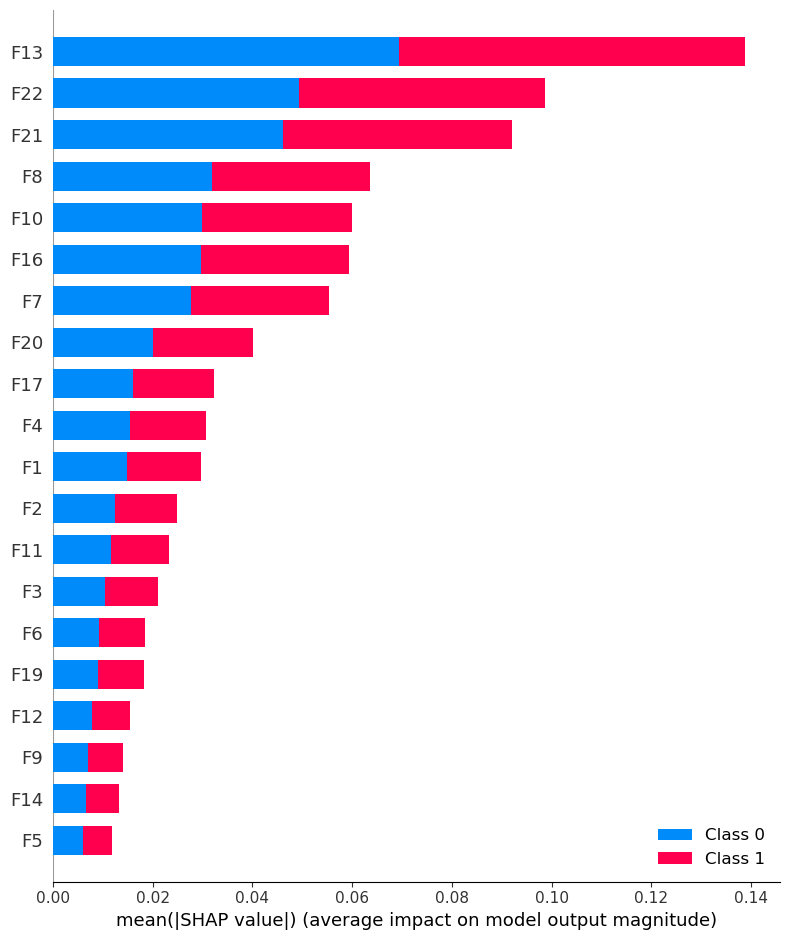

In [20]:
import shap

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(ensemble)

# Evaluate SHAP values
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_train, feature_names=dataset.feature_names)


In [24]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [26]:
# Evaluate SHAP values
shap_values = explainer(X_test)
print_feature_importances_shap_values(shap_values,dataset.feature_names)

F13 -> 0.0694 (softmax = 0.0478)
F22 -> 0.0493 (softmax = 0.0468)
F21 -> 0.0461 (softmax = 0.0467)
F8 -> 0.0318 (softmax = 0.0460)
F10 -> 0.0300 (softmax = 0.0459)
F16 -> 0.0297 (softmax = 0.0459)
F7 -> 0.0277 (softmax = 0.0458)
F20 -> 0.0201 (softmax = 0.0455)
F17 -> 0.0161 (softmax = 0.0453)
F4 -> 0.0154 (softmax = 0.0452)
F1 -> 0.0149 (softmax = 0.0452)
F2 -> 0.0124 (softmax = 0.0451)
F11 -> 0.0116 (softmax = 0.0451)
F3 -> 0.0105 (softmax = 0.0450)
F6 -> 0.0093 (softmax = 0.0450)
F19 -> 0.0091 (softmax = 0.0450)
F12 -> 0.0078 (softmax = 0.0449)
F9 -> 0.0070 (softmax = 0.0449)
F14 -> 0.0067 (softmax = 0.0448)
F5 -> 0.0060 (softmax = 0.0448)
F18 -> 0.0043 (softmax = 0.0447)
F15 -> 0.0042 (softmax = 0.0447)


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [27]:
shap.plots.bar(shap_values)

TypeError: only integer scalar arrays can be converted to a scalar index

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


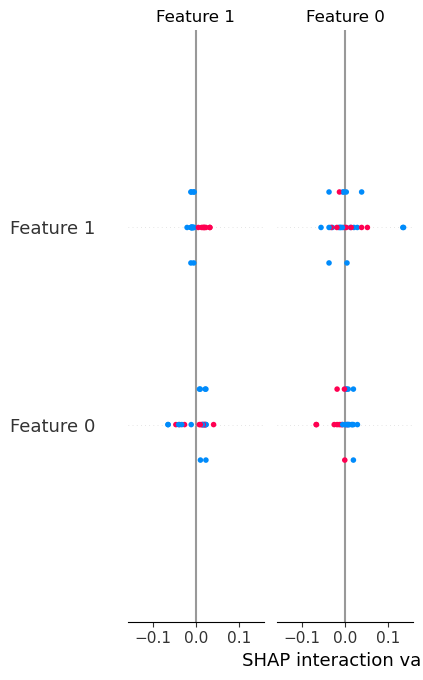

In [30]:
shap.summary_plot(shap_values)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


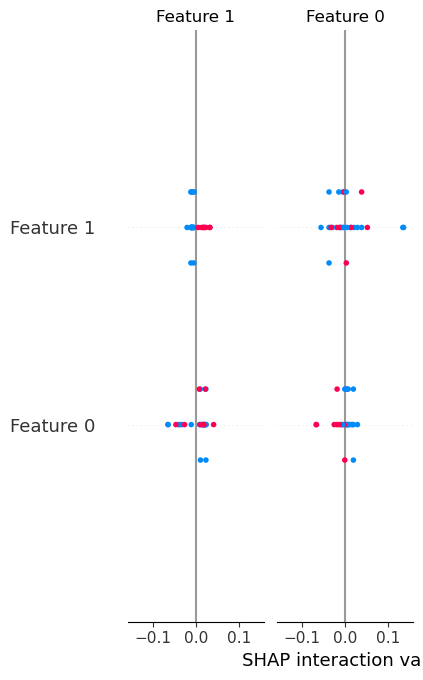

In [31]:
shap.summary_plot(shap_values, plot_type='violin')